![Basho Man](./Basho_Man_6.png)
### Use of the Riak-Spark-Connector to investigate traffic patterns at position '668' in Aarhus

From our earlier work (see the Jupyter Notebook 'Querying Aarhus2 data.ipynb'), we have some notion of the shape of the relevant dataset.  We think that what determines the vehicle count through that sensor reach could be a combination of:
* Hour of the day
* Day of the week
* Week of the year
* Month of the year

This notebook examines each of those variables in turn to see if our supposition holds any water.

In [1]:
#set the environment and load necessary libraries

import findspark
findspark.init()

import pyspark
from pyspark.sql import Row

conf = pyspark.SparkConf()
print conf.toDebugString()

sc = pyspark.SparkContext(conf=conf)
sqlContext = pyspark.SQLContext(sc)

spark.app.name=pyspark-shell
spark.master=local[*]
spark.submit.deployMode=client


In [2]:
#get our data

table_name="aarhus2"
start_date= 1392290000000
end_date = 1402292200000
status='OK'
extid='668'

host='127.0.0.1'
pb_port = '8087'
hostAndPort = ":".join([host, pb_port])

df = sqlContext.read\
    .format("org.apache.spark.sql.riak")\
    .option("spark.riak.connection.host", hostAndPort)\
    .option("spark.riakts.bindings.timestamp", "useLong")\
    .load(table_name)\
    .filter("""ts > %(start_date)s
        AND ts <  %(end_date)s
        AND status = '%(status)s'
        AND extid = '%(extid)s'
    """ % ({'start_date': start_date, 'end_date': end_date, 'status': status, 'extid': extid})) 
    
    #show we have got the data

df.printSchema()

df.show()

df.count()

root
 |-- status: string (nullable = false)
 |-- extid: string (nullable = false)
 |-- ts: long (nullable = false)
 |-- avgMeasuredTime: long (nullable = false)
 |-- avgSpeed: long (nullable = false)
 |-- medianMeasuredTime: long (nullable = false)
 |-- vehicleCount: long (nullable = false)
 |-- id: long (nullable = false)
 |-- report_id: long (nullable = false)

+------+-----+-------------+---------------+--------+------------------+------------+------+---------+
|status|extid|           ts|avgMeasuredTime|avgSpeed|medianMeasuredTime|vehicleCount|    id|report_id|
+------+-----+-------------+---------------+--------+------------------+------------+------+---------+
|    OK|  668|1392291000000|             66|      56|                66|           7|190000|   158324|
|    OK|  668|1392291300000|             69|      53|                69|           5|190449|   158324|
|    OK|  668|1392291600000|             69|      53|                69|           6|190898|   158324|
|    OK|  668|13

32059

We need to map values in the df to day of the week, week of the year, hour of the day and create subsidiary dataframes with the vehicle count and relevant "driving" variable.

In [3]:
#we only want ts and vehicleCount

df2=df['ts','vehicleCount']
df2.show()
print df2.count()

+-------------+------------+
|           ts|vehicleCount|
+-------------+------------+
|1392291000000|           7|
|1392291300000|           5|
|1392291600000|           6|
|1392291900000|           3|
|1392292200000|           6|
|1392292500000|           9|
|1392292800000|          11|
|1392293100000|           8|
|1392293400000|          10|
|1392293700000|          12|
|1392294000000|          16|
|1392294300000|          16|
|1392294600000|           8|
|1392294900000|           9|
|1392295200000|           8|
|1392295500000|           7|
|1392295800000|          11|
|1392296100000|           8|
|1392296400000|           8|
|1392296700000|           9|
+-------------+------------+
only showing top 20 rows

32059


In [4]:
#now to get day of the week

from datetime import datetime

def getDOW(row):
    dt=datetime.fromtimestamp(row[0]/1000)
    dow=dt.isoweekday()
    return Row(dow,row[1])

df3=df2.map(getDOW)

df31=df3.toDF()

print 'Control total ',df31.count(),'\n'
#print 'Column names ',df31.columns,'\n'
print 'Pearson correlation coefficient between those columns ',df31.corr('_1','_2'),'\n'
rdd31=df31.rdd
#print 'Counts of records by day of the week ',sorted(rdd31.countByKey().items()),'\n'

#try to get total counts by day of the week.
sum31=df31.groupBy('_1').sum().collect()
for r in sum31:
    print r[0],r[2]



Control total  32059 

Pearson correlation coefficient between those columns  -0.253149461566 

1 23939
2 25497
3 24722
4 23482
5 23088
6 9461
7 7853


In [5]:
#to chart our results

import matplotlib as plt
import pandas as pd
%matplotlib inline

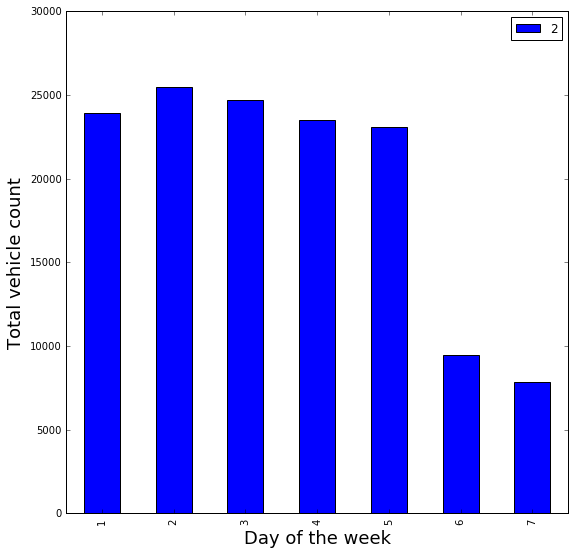

In [6]:
tdf=pd.DataFrame(sum31)
tdf.describe()
ax=tdf.plot(x=0,y=2,figsize=(9,9),kind='bar')
ax.set_ylabel('Total vehicle count', fontsize=18)
ax.set_xlabel('Day of the week', fontsize=18)

## STOP HERE FOR SALES TRAINING SESSION AND RUN NEXT CELL


In [7]:
sc.stop()

In [ ]:
#now to get week of the year

def getWOY(row):
    dt=datetime.fromtimestamp(row[0]/1000)
    woy=int(dt.strftime("%U"))
    return Row(woy,row[1])

df4=df2.map(getWOY)
df41=df4.toDF()

print 'Control total ',df41.count(),'\n'
#print 'Column names ',df41.columns,'\n'
print 'Pearson correlation coefficient between those columns ',df41.corr('_1','_2'),'\n'
rdd41=df41.rdd
#print 'Counts of records by week of the year ',sorted(rdd41.countByKey().items()),'\n'

#try to get total counts by week of the year.
sum41=df41.groupBy('_1').sum().collect()
for r in sum41:
    print r[0],r[2]

In [ ]:
tdf=pd.DataFrame(sum41)
tdf.describe()
ax=tdf.plot(x=0,y=2,figsize=(9,9),kind='bar')
ax.set_ylabel('Total vehicle count', fontsize=18)
ax.set_xlabel('Week of the year', fontsize=18)

In [ ]:
#month of the year
def getMOY(row):
    dt=datetime.fromtimestamp(row[0]/1000)
    moy=int(dt.strftime("%m"))
    print moy
    return Row(moy,row[1])

df5=df2.map(getMOY)
df51=df5.toDF()

print 'Control total ',df51.count(),'\n'
#print 'Column names ',df51.columns,'\n'
print 'Pearson correlation coefficient between those columns ',df51.corr('_1','_2'),'\n'
rdd51=df51.rdd
#print 'Counts of records by month of the year ',sorted(rdd51.countByKey().items()),'\n'

#try to get total counts by day of the week.
sum51=df51.groupBy('_1').sum().collect()
for r in sum51:
    print r[0],r[2]


In [ ]:
#to chart the results
tdf=pd.DataFrame(sum51)
tdf.describe()
ax=tdf.plot(x=0,y=2,figsize=(9,9),kind='bar')
ax.set_ylabel('Total vehicle count', fontsize=18)
ax.set_xlabel('Month of the year', fontsize=18)

In [ ]:
#hour of the day

def getHOD(row):
    dt=datetime.fromtimestamp(row[0]/1000)
    hod=dt.hour
    return Row(hod,row[1])

df6=df2.map(getHOD)
df61=df6.toDF()

print 'Control total ',df61.count(),'\n'
#print 'Column names ',df61.columns,'\n'
print 'Pearson correlation coefficient between those columns ',df61.corr('_1','_2'),'\n'
rdd61=df61.rdd
#print 'Counts of records by month of the year ',sorted(rdd51.countByKey().items()),'\n'

#try to get total counts by hour of the day
sum61=df61.groupBy('_1').sum().collect()
for r in sum61:
    print r[0],r[2]

In [ ]:
#to chart the results
tdf=pd.DataFrame(sum61)
tdf.describe()
ax=tdf.plot(x=0,y=2,figsize=(9,9),kind='bar')
ax.set_ylabel('Total vehicle count', fontsize=18)
ax.set_xlabel('Hour of the day', fontsize=18)

### Conclusion
From our analysis, it appears that the vehicleCount is related to:
* Day of the week
* Hour of the day